# **Import** **Libraries**

In [2]:
import pandas as pd
import numpy as np
import ser
import lib_tree
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report, precision_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score1
import time
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline

# Loading Datasets

In [3]:
Final_Data_S1= pd.read_csv("final_H358.csv")
Final_Data_S2= pd.read_csv("final_H355.csv")
Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin([ 3.0,4.0])].index, 'labels']=2.0
Final_Data_S2.loc[Final_Data_S2[Final_Data_S2.labels.isin([ 3.0,4.0])].index, 'labels']=2.0
ys = Final_Data_S1.labels
Xs= Final_Data_S1.drop(['Time', 'labels'], axis=1)
yt = Final_Data_S2.labels
Xt= Final_Data_S2.drop(['Time', 'labels'], axis=1)

In [4]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.25, stratify=yt,  random_state = 42)
test_data = pd.concat([X_test_t, y_test_t], axis=1)
training_data = pd.concat([X_train_t, y_train_t], axis=1)
test_data.to_csv('test_data.csv', index=False)  # Set index=False to avoid saving the row indices
training_data.to_csv('train_data.csv', index=False)

In [5]:
train= training_data
test= test_data

class_counts = test['labels'].value_counts()

print("Number of instances per class:")
print(class_counts)

yt = train.labels
Xt= train.drop([ 'labels'], axis=1)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.9, stratify=yt,  random_state = 42)
X_train_t = X_train_t.to_numpy()
y_train_t= y_train_t.to_numpy()
y_test_t = test.labels
X_test_t = test.drop([ 'labels'], axis=1)

clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(Xs, ys)
MAX = 3
target_names = ['Class 0', 'Class 1', 'Class 2']

Number of instances per class:
labels
0    193
1     48
2     26
Name: count, dtype: int64


In [ ]:
y_pred =  clf.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
f1_weighted = f1_score(y_pred, y_test_t, average='weighted')
print("accuracy:",accuracy_score(y_test_t, y_pred))
print('Weighted F1 score: ', f1_weighted)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix no TL:")
print(cm)

accuracy: 0.6479400749063671
Weighted F1 score:  0.6580080047494871
precision: [0.89349112 0.         0.22680412]
recall; [0.78238342 0.         0.84615385]
fscore: [0.83425414 0.         0.35772358]
support: [193  48  26]
Confusion Matrix no TL:
[[151   0  42]
 [ 15   0  33]
 [  3   1  22]]


Micro-averaged One-vs-Rest ROC AUC score:
0.7360
Macro-averaged One-vs-Rest ROC AUC score:
0.68


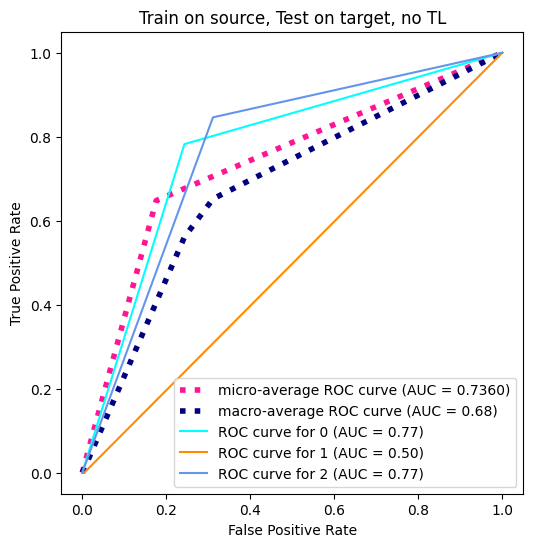

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
label_binarizer = LabelBinarizer().fit(y_test_t)
y_onehot_test = label_binarizer.transform(y_test_t)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform([0])

import matplotlib.pyplot as plt

y_pred_onehot = label_binarizer.transform(y_pred)



from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))


from sklearn.metrics import auc, roc_curve
n_classes = 3
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.4f}")
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.4f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_onehot[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
        #plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train on source, Test on target, no TL")
plt.legend()
plt.show()

In [ ]:
model = DecisionTreeClassifier(max_depth=3)
model = model.fit(X_train_t, y_train_t)
y_pred =  model.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
f1_weighted = f1_score(y_pred, y_test_t, average='weighted')

print("accuracy:",accuracy_score(y_test_t, y_pred))
print('Weighted F1 score: ', f1_weighted)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix:")
print(cm)

accuracy: 0.7790262172284644
Weighted F1 score:  0.7639080777530597
precision: [0.97515528 0.44210526 0.81818182]
recall; [0.8134715  0.875      0.34615385]
fscore: [0.88700565 0.58741259 0.48648649]
support: [193  48  26]
Confusion Matrix:
[[157  36   0]
 [  4  42   2]
 [  0  17   9]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [12]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model = model.fit(X_train_t, y_train_t)
y_pred =  model.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
f1_weighted = f1_score(y_pred, y_test_t, average='weighted')

print("accuracy:",accuracy_score(y_test_t, y_pred))
print('Weighted F1 score: ', f1_weighted)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix:")
print(cm)

accuracy: 0.7790262172284644
Weighted F1 score:  0.7639080777530597
precision: [0.97515528 0.44210526 0.81818182]
recall; [0.8134715  0.875      0.34615385]
fscore: [0.88700565 0.58741259 0.48648649]
support: [193  48  26]
Confusion Matrix:
[[157  36   0]
 [  4  42   2]
 [  0  17   9]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Micro-averaged One-vs-Rest ROC AUC score:
0.8343
Macro-averaged One-vs-Rest ROC AUC score:
0.7884


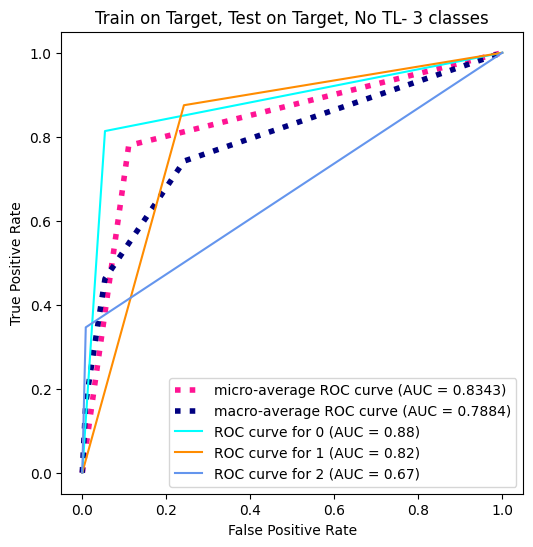

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
label_binarizer = LabelBinarizer().fit(y_test_t)
y_onehot_test = label_binarizer.transform(y_test_t)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform([0])

import matplotlib.pyplot as plt

y_pred_onehot = label_binarizer.transform(y_pred)



from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))


from sklearn.metrics import auc, roc_curve
n_classes = 3
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.4f}")
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.4f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.4f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.4f}")
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_onehot[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
        #plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train on Target, Test on Target, No TL- 3 classes")
plt.legend()
plt.show()

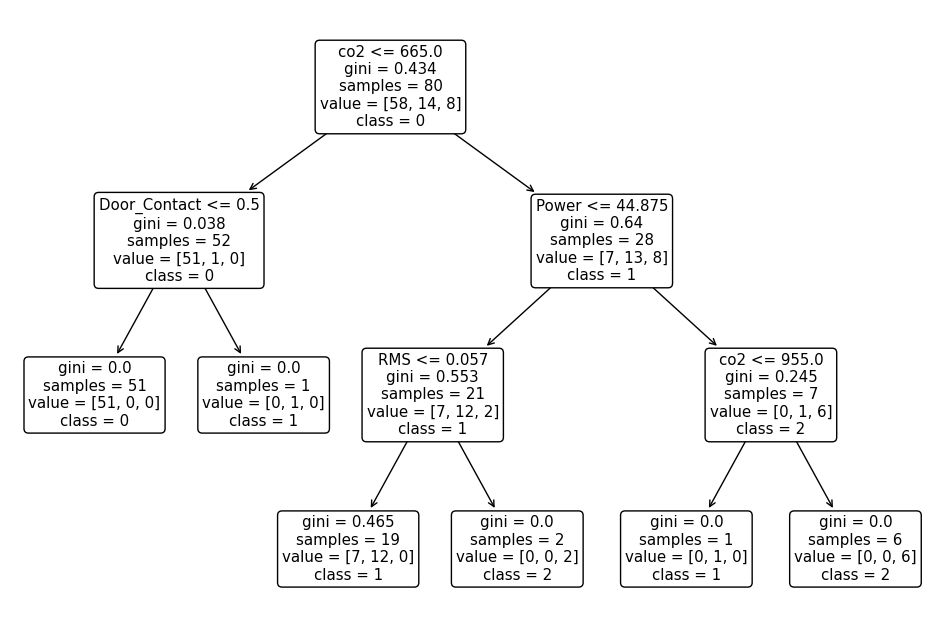

In [13]:
plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact', 'Window_Contact'], class_names=['0','1', '2'], rounded=True)
plt.show()

## **Transfer Learning**

# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_train_t, y_train_t)


In [ ]:
SER_smote = copy.deepcopy(clf)
ser.SER(0, SER_smote, X_resampled, y_resampled, original_ser=True)
#print('ser naive random over-sampling accuracy:', SER_oversampled.score(X_resampled, y_resampled))
y_pred = SER_smote.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
print("accuracy:",accuracy_score(y_test_t, y_pred))
f1_weighted = f1_score( y_test_t, y_pred,average='weighted')
print('weighted f1 score:', f1_weighted)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix ser smote:")
print(cm)

accuracy: 0.8052434456928839
weighted f1 score: 0.8090234589810446
precision: [0.95744681 0.48148148 0.36      ]
recall; [0.93264249 0.54166667 0.34615385]
fscore: [0.94488189 0.50980392 0.35294118]
support: [193  48  26]
Confusion Matrix ser smote:
[[180  12   1]
 [  7  26  15]
 [  1  16   9]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


precision: [0.95744681 0.48148148 0.36      ]
recall; [0.93264249 0.54166667 0.34615385]
fscore: [0.94488189 0.50980392 0.35294118]
support: [193  48  26]
accuracy: 0.850187265917603
Confusion Matrix ser smote:
[[178  15   0]
 [  7  39   2]
 [  1  15  10]]


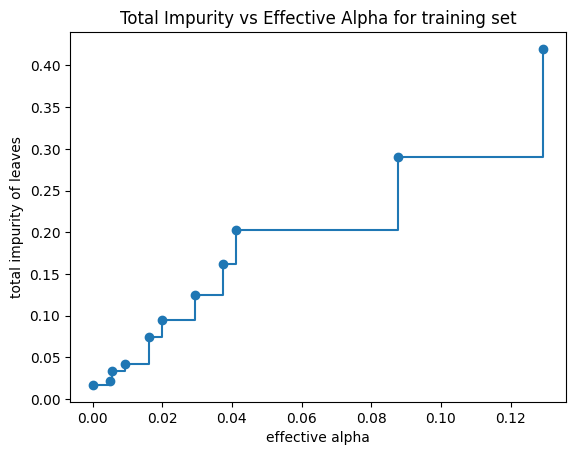

In [ ]:

# Assuming you have already defined dt_new and X_train_res, y_train_res

# Path for cost complexity pruning
path = SER_smote.cost_complexity_pruning_path( X_resampled, y_resampled)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the pruning path
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs Effective Alpha for training set")

# Find the optimal value for ccp_alpha
optimal_ccp_alpha = ccp_alphas[np.argmin(impurities)]

# Create a new DecisionTreeClassifier with ccp_alpha parameter set
SER_smote = DecisionTreeClassifier(ccp_alpha=optimal_ccp_alpha)

# Re-fit the tree
SER_smote.fit(X_resampled, y_resampled)

y_pred = SER_smote.predict(X_test_t)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
print("accuracy:",accuracy_score(y_test_t, y_pred))
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix ser smote:")
print(cm)

In [ ]:
f1_weighted = f1_score(y_pred, y_test_t, average='weighted')
print('weighted f1 score:', f1_weighted)

weighted f1 score: 0.8502928484235699


Micro-averaged One-vs-Rest ROC AUC score:
0.8843
Macro-averaged One-vs-Rest ROC AUC score:
0.8241


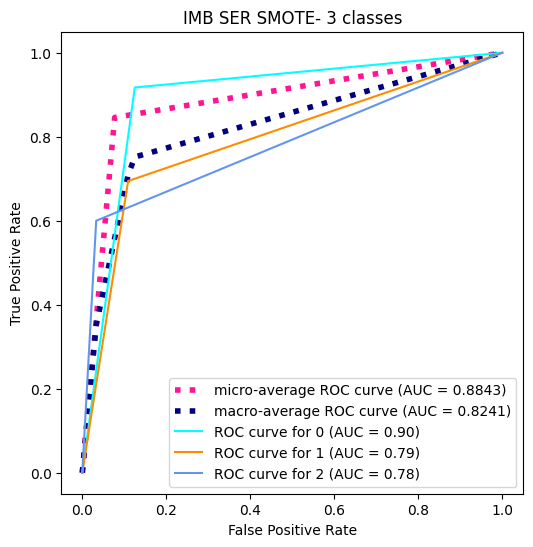

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
label_binarizer = LabelBinarizer().fit(y_test_t)
y_onehot_test = label_binarizer.transform(y_test_t)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform([0])

import matplotlib.pyplot as plt

y_pred_onehot = label_binarizer.transform(y_pred)



from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))


from sklearn.metrics import auc, roc_curve
n_classes = 3
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.4f}")
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.4f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.4f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.4f}")
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_onehot[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
        #plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IMB SER SMOTE- 3 classes")
plt.legend()
plt.show()

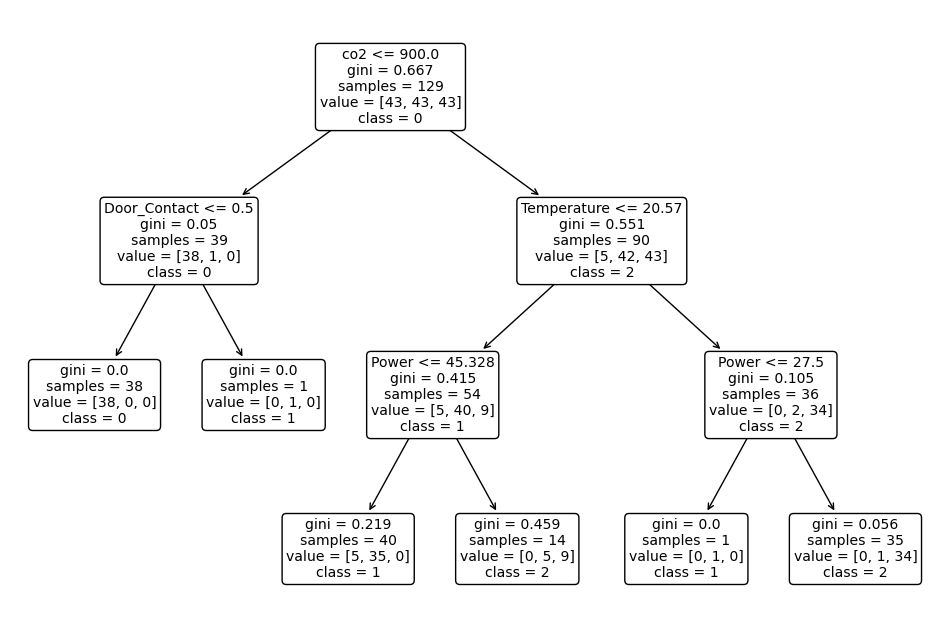

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(SER_smote, feature_names=['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact', 'Window_Contact'], class_names=['0','1','2'], rounded=True)
plt.show()

## UNDERSAMPLING

In [9]:
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(
    estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42, sampling_strategy='not majority'
)
X_res, y_res = cc.fit_resample(X_train_t, y_train_t)
SER_cluster = copy.deepcopy(clf)
ser.SERRR(0, SER_cluster, X_res, y_res, original_ser=True)
#print('ser naive random over-sampling accuracy:', SER_oversampled.score(X_resampled, y_resampled))
y_pred = SER_cluster.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
print("accuracy:",accuracy_score(y_test_t, y_pred))
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix ser smote:")
print(cm)

precision: [0.86425339 0.6        0.5       ]
recall; [0.98963731 0.25       0.5       ]
fscore: [0.92270531 0.35294118 0.5       ]
support: [193  48  26]
accuracy: 0.8089887640449438
Confusion Matrix ser smote:
[[191   2   0]
 [ 23  12  13]
 [  7   6  13]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


accuracy: 0.8557213930348259
precision: [0.90322581 0.64       0.76190476]
recall; [0.96551724 0.44444444 0.8       ]
fscore: [0.93333333 0.52459016 0.7804878 ]
support: [145  36  20]
Confusion Matrix imb ser ClusterCentroids:
[[140   5   0]
 [ 15  16   5]
 [  0   4  16]]


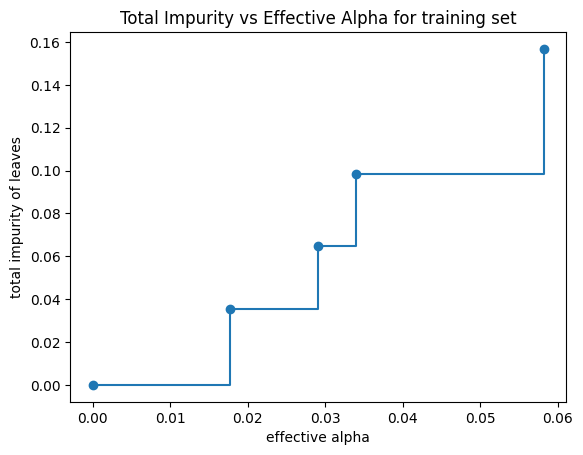

In [ ]:
# Assuming you have already defined dt_new and X_train_res, y_train_res

# Path for cost complexity pruning
path = SER_cluster.cost_complexity_pruning_path(X_res, y_res)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the pruning path
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs Effective Alpha for training set")

# Find the optimal value for ccp_alpha
optimal_ccp_alpha = ccp_alphas[np.argmin(impurities)]

# Create a new DecisionTreeClassifier with ccp_alpha parameter set
SER_cluster = DecisionTreeClassifier(ccp_alpha=optimal_ccp_alpha, max_depth = 3)

# Re-fit the tree
SER_cluster.fit(X_res, y_res)

y_pred = SER_cluster.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)

print("accuracy:",accuracy_score(y_test_t, y_pred))
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix imb ser ClusterCentroids:")
print(cm)

In [ ]:
f1_weighted = f1_score(y_pred, y_test_t, average='weighted')
print('weighted f1 score:', f1_weighted)

weighted f1 score: 0.8665256948630167


Micro-averaged One-vs-Rest ROC AUC score:
0.8918
Macro-averaged One-vs-Rest ROC AUC score:
0.8100


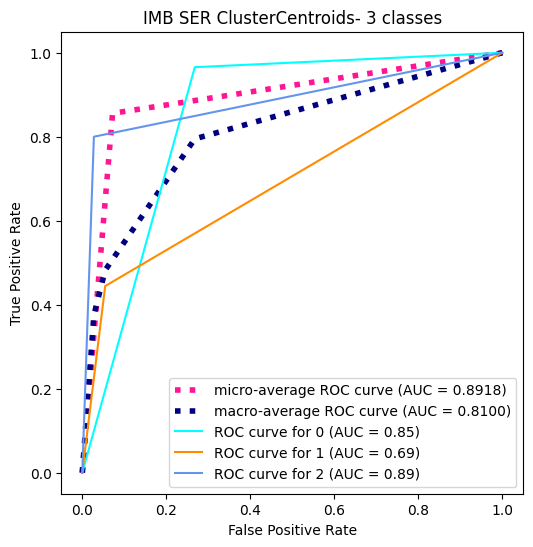

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
label_binarizer = LabelBinarizer().fit(y_test_t)
y_onehot_test = label_binarizer.transform(y_test_t)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform([0])

import matplotlib.pyplot as plt

y_pred_onehot = label_binarizer.transform(y_pred)



from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))


from sklearn.metrics import auc, roc_curve
n_classes = 3
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.4f}")
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.4f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.4f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.4f}")
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_onehot[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
        #plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IMB SER ClusterCentroids- 3 classes")
plt.legend()
plt.show()

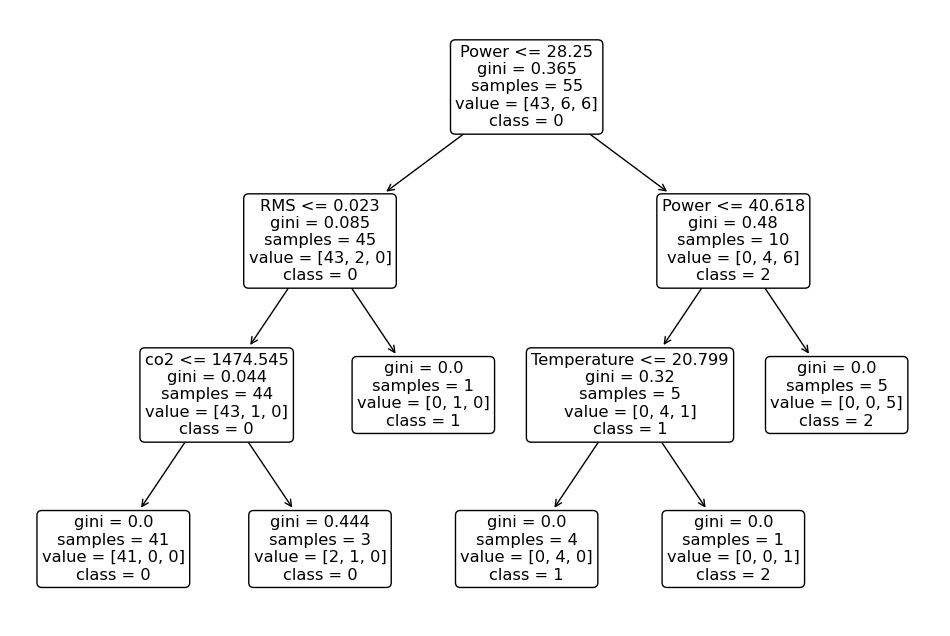

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(SER_cluster, feature_names=['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact', 'Window_Contact'], class_names=['0','1','2'], rounded=True)
plt.show()

In [ ]:
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X_train_t, y_train_t)

SER_tomek = copy.deepcopy(clf)
ser.SER(0, SER_tomek, X_res, y_res, original_ser=True)
#print('ser naive random over-sampling accuracy:', SER_oversampled.score(X_resampled, y_resampled))
y_pred = SER_tomek.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
print("accuracy:",accuracy_score(y_test_t, y_pred))
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix imb ser smotetomek:")
print(cm)


precision: [0.98561151 0.58139535 0.42105263]
recall; [0.94482759 0.69444444 0.4       ]
fscore: [0.96478873 0.63291139 0.41025641]
support: [145  36  20]
accuracy: 0.845771144278607
Confusion Matrix imb ser smotetomek:
[[137   6   2]
 [  2  25   9]
 [  0  12   8]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


precision: [0.97163121 0.65714286 0.6       ]
recall; [0.94482759 0.63888889 0.75      ]
fscore: [0.95804196 0.64788732 0.66666667]
support: [145  36  20]
accuracy: 0.8706467661691543
Confusion Matrix ser smotetomek:
[[137   8   0]
 [  3  23  10]
 [  1   4  15]]


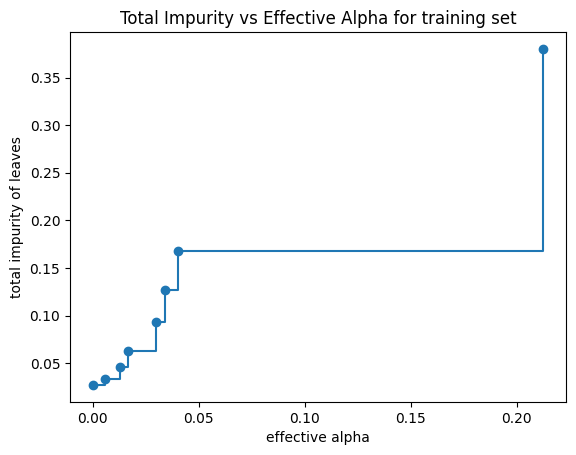

In [ ]:
# Assuming you have already defined dt_new and X_train_res, y_train_res

# Path for cost complexity pruning
path = SER_tomek.cost_complexity_pruning_path(X_res, y_res)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the pruning path
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs Effective Alpha for training set")

# Find the optimal value for ccp_alpha
optimal_ccp_alpha = ccp_alphas[np.argmin(impurities)]

# Create a new DecisionTreeClassifier with ccp_alpha parameter set
SER_tomekk = DecisionTreeClassifier(ccp_alpha=optimal_ccp_alpha, max_depth=3)

# Re-fit the tree
SER_tomekk.fit(X_res, y_res)

y_pred = SER_tomekk.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
print("accuracy:",accuracy_score(y_test_t, y_pred))
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix ser smotetomek:")
print(cm)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


precision: [0.96341463 0.42391304 0.72727273]
recall; [0.81865285 0.8125     0.30769231]
fscore: [0.88515406 0.55714286 0.43243243]
support: [193  48  26]
accuracy: 0.7677902621722846
Confusion Matrix ser smotetomek:
[[158  35   0]
 [  6  39   3]
 [  0  18   8]]


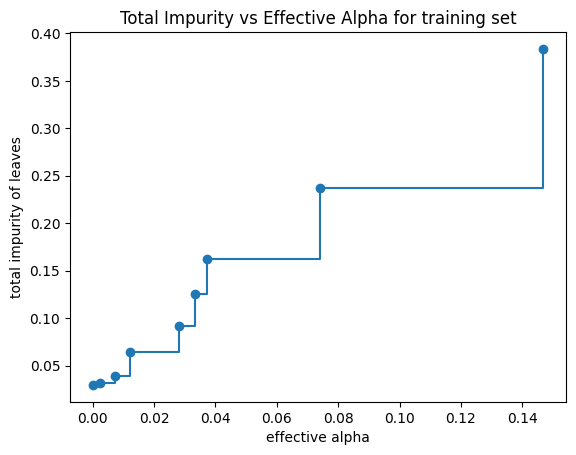

In [ ]:
# Assuming you have already defined dt_new and X_train_res, y_train_res

# Path for cost complexity pruning
path = SER_tomek.cost_complexity_pruning_path(X_res, y_res)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the pruning path
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs Effective Alpha for training set")

# Find the optimal value for ccp_alpha
optimal_ccp_alpha = ccp_alphas[np.argmin(impurities)]

# Create a new DecisionTreeClassifier with ccp_alpha parameter set
SER_tomekk = DecisionTreeClassifier(ccp_alpha=optimal_ccp_alpha, max_depth=3, class_weight='balanced')

# Re-fit the tree
SER_tomekk.fit(X_res, y_res)

y_pred = SER_tomekk.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
print("accuracy:",accuracy_score(y_test_t, y_pred))
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix ser smotetomek:")
print(cm)

In [ ]:
f1_weighted = f1_score(y_pred, y_test_t, average='weighted')
print('weighted f1 score:', f1_weighted)

weighted f1 score: 0.8677942243214473


Micro-averaged One-vs-Rest ROC AUC score:
0.9030
Macro-averaged One-vs-Rest ROC AUC score:
0.8557


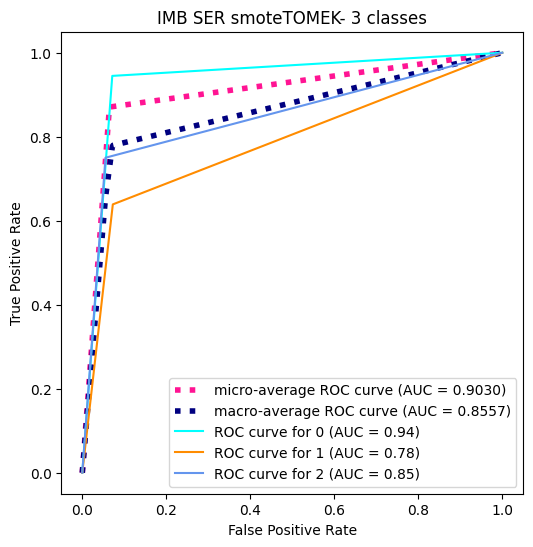

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
label_binarizer = LabelBinarizer().fit(y_test_t)
y_onehot_test = label_binarizer.transform(y_test_t)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform([0])

import matplotlib.pyplot as plt

y_pred_onehot = label_binarizer.transform(y_pred)



from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))


from sklearn.metrics import auc, roc_curve
n_classes = 3
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.4f}")
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.4f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.4f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.4f}")
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_onehot[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
        #plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IMB SER smoteTOMEK- 3 classes")
plt.legend()
plt.show()

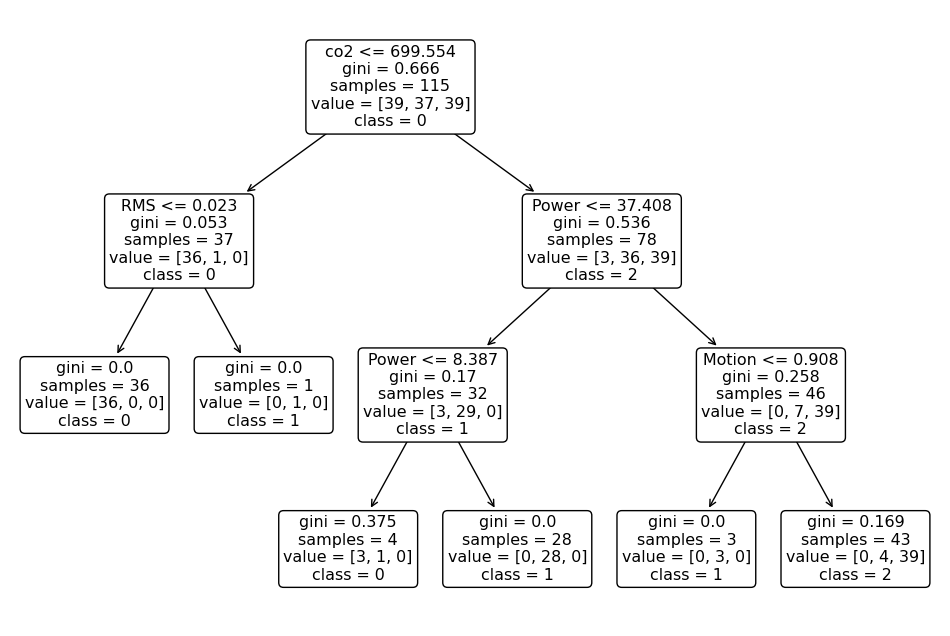

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(SER_tomekk, feature_names=['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact', 'Window_Contact'], class_names=['0','1','2'], rounded=True)
plt.show()